In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# import h5py
# halo_fname = 'RShalos_allprops.hdf5'
# f = h5py.File(halo_fname,'r')
# halos = f['halos']
# #print(halos.dtype)
# mass = halos['m'] # which mass is this?
# sel = mass > 1e+13
# lnM = np.log(mass[sel])
# beta = 2 

# Define exponential mass function

$n_{1}(\mu)=A e^{-\beta_{1} \mu}$

$\beta = 1.6$
$M_p = 1E12$

In [74]:
from scipy.stats import expon
beta = 1.6
lnM = expon.rvs(loc=np.log(1e12), scale=1/beta, size=10**8)
lnM = lnM[lnM > np.log(1e13)]

In [75]:
print(min(lnM), max(lnM))

29.933606355598368 39.24298484251779


Text(0, 0.5, 'Count')

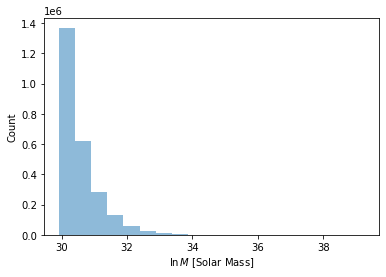

In [76]:
bins = np.linspace(min(lnM), max(lnM), 20)
plt.hist(lnM, alpha=0.5, label='exp', bins=bins)
plt.xlabel("$\ln M$ [Solar Mass]")
plt.ylabel("Count")
# plt.hist(lnM_real, density=True, alpha=0.5, label='HMF', bins=bins)
# plt.legend()
# plt.yscale('log')

1.7188694225033396 10755.506784509344


(array([2.516232e+06, 3.800000e+01, 5.000000e+00, 3.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([1.71886942e+00, 1.07709766e+03, 2.15247645e+03, 3.22785524e+03,
        4.30323404e+03, 5.37861283e+03, 6.45399162e+03, 7.52937041e+03,
        8.60474920e+03, 9.68012799e+03, 1.07555068e+04]),
 <BarContainer object of 10 artists>)

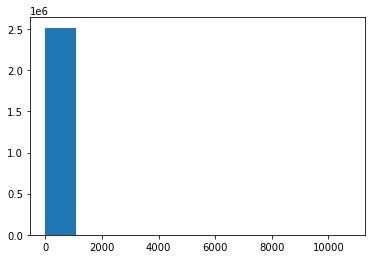

In [77]:
#richness scaling relation
Alam = 0.939
Blam = 0.32
Mpiv = 5e+14
z = 0.3
lnlam0 = 4.25 - Alam * np.log(Mpiv) + Blam * np.log((1+z)/1.45)

lnlam_mean = lnlam0 + Alam * lnM
print(min(np.exp(lnlam_mean)), max(np.exp(lnlam_mean)))
# there are several very big ones because of the exponential distribution

bins = np.linspace(min(np.exp(lnlam_mean)), max(np.exp(lnlam_mean)),20)
plt.hist(np.exp(lnlam_mean))

In [78]:
#SZ scaling relation
lnASZ = np.log(5.24)
BSZ = 1.534
CSZ = 0.465

# 0.161
lnSZ_mean = lnASZ + BSZ * (lnM - np.log(4.3e+14)) + CSZ * np.log(1) # TODO

In [79]:
import copy
lnMwl_mean = copy.deepcopy(lnM)
nh = len(lnM)
from scipy.stats import multivariate_normal
from scipy.stats import norm

# MonteCarlo

First, Monte Carlo from the covariance matrix and the mean. How does this work? 

Second, define a narrow richness bin to mimic the distribution of halo mass given richness. The expectation value given no correlation should be 
$$\frac{\lambda-\pi_{\lambda}}{\alpha_{\lambda}}$$

But the downward correction is 
$$-(\frac{\sigma_\lambda}{\alpha})^2 \beta$$

Third, 

In [80]:
class MonteCarloObservables(object):
    def __init__(self, r, scatter_wl=0.2, scatter_lam=0.3, scatter_SZ=0.151):
        self.r = r
        self.scatter_wl = scatter_wl
        self.scatter_lam = scatter_lam
        self.scatter_SZ = scatter_SZ
        mv = multivariate_normal([0, 0], [[1, r], [r, 1]])
        rv = mv.rvs(size=nh)
        x = rv[:,0]
        y = rv[:,1] 
        
        gauss = norm(0,1)
        z = gauss.rvs(size=nh)
 
        self.lnlam = lnlam_mean + scatter_lam * x
        self.lnMwl = lnMwl_mean + scatter_wl * y
        self.lnSZ = lnSZ_mean = scatter_SZ * z 
    
    
    def calculate_diff_mean_halomass_given_lambda(self, lnlam_min = np.log(20), lnlam_max = np.log(21)):        
        
        sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
        mean_mass_numerical = np.mean(self.lnMwl[sel3])
    
        # Evrard equation.
        lnM_expected = (self.lnlam[sel3]-lnlam0) / Alam # expectation of no scatter
        mean_mass_theory = np.mean(lnM_expected - beta * (self.scatter_lam / Alam)**2)

        return mean_mass_numerical - mean_mass_theory
    

    def mass_selection_matching_lambda(self, lnM_min=np.log(1e14), lnM_max=np.log(1.1e14)):
        
        sel = (lnM > lnM_min)&(lnM < lnM_max) #Selecting on mass 
        lnM_sel = np.mean(lnM[sel]) #the true halo mass 

        lnlam_sel = self.lnlam[sel] #richness of the halos selected
        
        nbins = 100
        lnlam_bins = np.linspace(min(lnlam_sel)-0.1, max(lnlam_sel)+0.1, nbins+1) 
        #very narrow lambda bins

        lnM_weighted = 0 #initialize empty variable
        mean_mass_theory = 0 # make prediction one bin at a time
        
        for i in range(nbins):
            #define edges of the richness bin
            lnlam_min = lnlam_bins[i]
            lnlam_max = lnlam_bins[i+1]
            
            
            #lambda selection to calculate the weight
            sel2 = (lnlam_sel >= lnlam_min)&(lnlam_sel < lnlam_max)
            weight = len(lnlam_sel[sel2])/len(lnlam_sel)
            
            if weight > 0:
                
                #Calculate the mean mass weighted by 
                sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
                lnM_weighted += np.mean(lnM[sel3]) * weight
                
                
                #Calculate the theoretical mean mass 
                lnM_expected = np.mean((self.lnlam[sel3]-lnlam0) / Alam)
                pred = lnM_expected - beta * (self.scatter_lam / Alam)**2 
                mean_mass_theory += pred * weight
                
        return lnM_weighted - mean_mass_theory

## selecting on a lambda bin

In [81]:
mco = MonteCarloObservables(0, scatter_lam=0.2, scatter_wl=0)

In [82]:
nlam = 20
lam_bin_list = np.linspace(np.log(20), np.log(100), nlam+1)
diff_list = np.zeros(nlam)
for i in range(nlam):
    diff_list[i] = mco.calculate_diff_mean_halomass_given_lambda(lam_bin_list[i], lam_bin_list[i+1]) #+np.log(2)

lam_bin_mid = (lam_bin_list[0:-1] + lam_bin_list[1:]) / 2.

Text(0, 0.5, '$\\rm \\langle ln M\\rangle$ numerical - thoery')

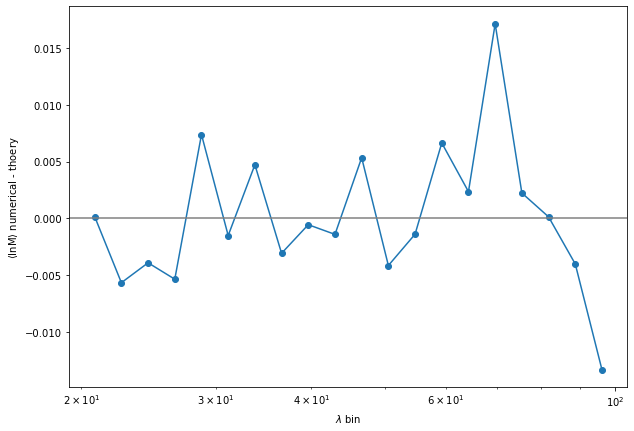

In [83]:
plt.figure(figsize=(10,7))
plt.semilogx(np.exp(lam_bin_mid), diff_list, 'o-')
plt.axhline(0, c='gray')
plt.xlabel(r'$\lambda$ bin')
plt.ylabel(r'$\rm \langle ln M\rangle$ numerical - thoery')

## selection on a mass bin, matching lambda

In [84]:
mco = MonteCarloObservables(0, scatter_lam=0.2, scatter_wl=0)
nM = 20
lnM_bin_list = np.linspace(np.log(5e13), np.log(1e+15), nlam+1)
diff_list = np.zeros(nM)
for i in range(nM):
    diff_list[i] = mco.mass_selection_matching_lambda(lnM_bin_list[i], lnM_bin_list[i+1])

Text(0, 0.5, '$\\rm \\langle ln M\\rangle$ numerical - thoery')

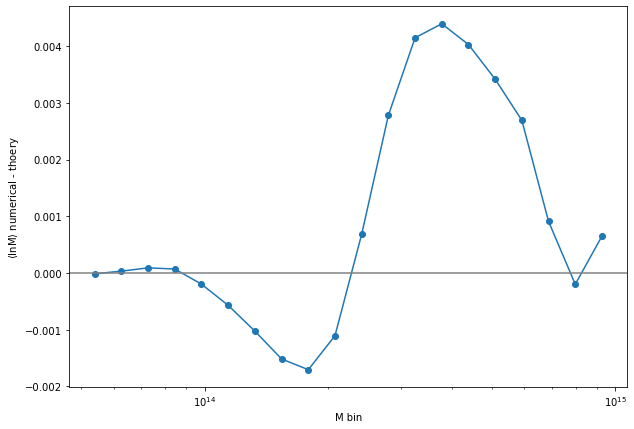

In [85]:
plt.figure(figsize=(10,7))
lnM_bin_mid = (lnM_bin_list[0:-1] + lnM_bin_list[1:]) / 2.
plt.semilogx(np.exp(lnM_bin_mid), diff_list, 'o-')
plt.axhline(0, c='gray')
plt.xlabel(r'M bin')
plt.ylabel(r'$\rm \langle ln M\rangle$ numerical - thoery')

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
x = np.logspace(1,10,10)

In [21]:
y = 2*x + 1E10

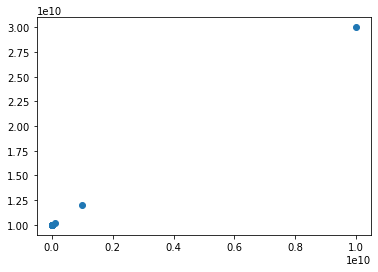

In [22]:
plt.scatter(x,y)

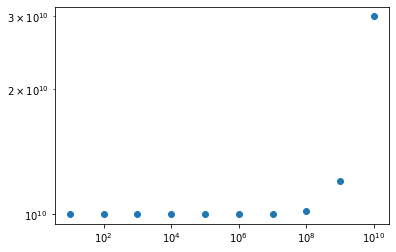

In [23]:
plt.scatter(x,y)
plt.xscale('log')
plt.yscale('log')